In [459]:
%%html
<style>
    body {
        font-family: "Times New Roman", Times, serif; 
    }
</style>

## 1. Report 10-fold cross-validation (“CV”) performances of the following types of classifiers, using default parameters: 

In [460]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv('heart.csv')

df


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


Extract the dependent variable

In [461]:
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']


Transform nominal features to numerical. Also conduct standarization to the numerical features.

In [462]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Standarization
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Nominal to numerical
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

X

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,-0.551341,1.382928,-0.832432,True,True,False,False,True,False,False,False,True
1,-0.478484,1.491752,-0.171961,-0.551341,0.754157,0.105664,False,False,True,False,True,False,False,True,False
2,-1.751359,-0.129513,0.770188,-0.551341,-1.525138,-0.832432,True,True,False,False,False,True,False,False,True
3,-0.584556,0.302825,0.139040,-0.551341,-1.132156,0.574711,False,False,False,False,True,False,True,True,False
4,0.051881,0.951331,-0.034755,-0.551341,-0.581981,-0.832432,True,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.902775,-1.210356,0.596393,-0.551341,-0.188999,0.293283,True,False,False,True,True,False,False,True,False
914,1.536902,0.627078,-0.053049,1.813758,0.164684,2.357094,True,False,False,False,True,False,False,True,False
915,0.370100,-0.129513,-0.620168,-0.551341,-0.857069,0.293283,True,False,False,False,True,False,True,True,False
916,0.370100,-0.129513,0.340275,-0.551341,1.461525,-0.832432,False,True,False,False,False,False,False,True,False


In [463]:
# Convert DataFrame to numpy array
X=X.values
y=y.values

X

array([[-1.4331398004436657, 0.4109088920930765, 0.825070260880155, ...,
        False, False, True],
       [-0.47848358571613486, 1.4917523389166985, -0.171961047319812,
        ..., False, True, False],
       [-1.751358538686176, -0.12951283131873445, 0.7701878035480467,
        ..., False, False, True],
       ...,
       [0.37009971626389254, -0.12951283131873445, -0.6201677821986963,
        ..., True, True, False],
       [0.37009971626389254, -0.12951283131873445, 0.3402752211131986,
        ..., False, True, False],
       [-1.6452856259386726, 0.3028245474107143, -0.21769642842990222,
        ..., False, False, True]], dtype=object)

Define the classifiers

In [464]:
classifiers = {
    'GaussianNB': GaussianNB(),
    'Linear SVC': SVC(kernel='linear', probability=True),
    'MLPClassifier': MLPClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

Define the evaluation function, 10-fold CV

In [465]:
def eval_classifier(_clf, _X, _y):
    accuracies = []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    for train_index, test_index in kf.split(_X, _y):
        _clf.fit(_X[train_index], _y[train_index])
        y_pred = _clf.predict(_X[test_index])
        accuracies += [accuracy_score(_y[test_index], y_pred)]
    return np.array(accuracies)

In [466]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

for name, clf in classifiers.items():
    acc = eval_classifier(clf, X, y)  
    print(f'{name} CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

GaussianNB CV accuracy=0.86 ±0.037
Linear SVC CV accuracy=0.86 ±0.025
MLPClassifier CV accuracy=0.87 ±0.029
DecisionTreeClassifier CV accuracy=0.79 ±0.035


In [467]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
rf_score = rf_clf.score(X_test, y_test)
print(f"RandomForestClassifier Test Accuracy: {rf_score:.2f}")


RandomForestClassifier Test Accuracy: 0.85


## 2. Generate an ensemble of 100 classifiers for each of the four basic classifiers in Q1. and store each ensemble as a list.

In [479]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ensemble_size = 100
# store each ensemble as a list
ensembles = {
    'GaussianNB': [GaussianNB() for _ in range(ensemble_size)],
    'LinearSVC': [SVC(kernel='linear', probability=True) for _ in range(ensemble_size)],
    'MLPClassifier': [MLPClassifier(hidden_layer_sizes=(3, 3), max_iter=30, tol=1e-1, random_state=42) for _ in range(ensemble_size)],
    'DecisionTreeClassifier': [DecisionTreeClassifier(max_depth=5, max_features=5, random_state=42) for _ in range(ensemble_size)]
}

In [480]:
results = {}
for name, classifier in ensembles.items():
    classifier[0].fit(X_train, y_train)  # Train the first classifier
    y_pred = classifier[0].predict(X_test)  # Predict the test set
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results[name] = accuracy
    print(f"Accuracy of the first {name}: {accuracy:.2f}")

Accuracy of the first GaussianNB: 0.86
Accuracy of the first LinearSVC: 0.85
Accuracy of the first MLPClassifier: 0.47
Accuracy of the first DecisionTreeClassifier: 0.86


## 3. Write a function ensemble_fit() to receive the ensemble (i.e. one of the 4 lists from Q2.) as an input and train it on one of the subsets (i.e. bagging) of the training data.

only subsample the rows/observations.

In [446]:
import random

def randomsubset(total_samples, subset_size):
     return random.sample(range(total_samples), subset_size)

In [447]:
def ensemble_fit(ensemble, X_train, y_train, subset_size):
    n_samples = X_train.shape[0]
    trained_ensemble = []
    for clf in ensemble:
        # Get a random subset of indices
        indices = randomsubset(n_samples, subset_size)
        
        # Subset the training data
        X_subset = X_train[indices]
        y_subset = y_train[indices]
        
        # Train the classifier on the subset
        clf.fit(X_subset, y_subset)

        predictions = clf.predict(X_test)
        trained_ensemble.append(clf)
    return trained_ensemble


trained_ensembles = {name: ensemble_fit(clfs, X_train, y_train, subset_size=100) for name, clfs in ensembles.items()}

def evaluate_classifier(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Print the performance
for ensemble_name, classifier in trained_ensembles.items():
    first_clf = classifier[0]  # Get the first classifier from the ensemble
    accuracy = evaluate_classifier(first_clf, X_test, y_test)
    print(f"Accuracy of the first {ensemble_name} classifier: {accuracy:.2f}")

Accuracy of the first GaussianNB classifier: 0.85
Accuracy of the first LinearSVC classifier: 0.82
Accuracy of the first MLPClassifier classifier: 0.42
Accuracy of the first DecisionTreeClassifier classifier: 0.79


## 4. Write a function ensemble_predict() to receive the trained ensemble (i.e. one of the lists from Q3.) as input and output a prediction for a given observation.

In [448]:
def ensemble_predict(ensemble, X):
    probas = np.zeros((X.shape[0], 2))
    proba_predictions = [clf.predict_proba(X) for clf in ensemble]
    summed_probabilities = np.sum(proba_predictions, axis=0)

    # Choose the class with the highest summed probabilities for each sample
    final_predictions = np.argmax(summed_probabilities, axis=1)

    return final_predictions

for ensemble_name, classifier in trained_ensembles.items():
    predictions = ensemble_predict(classifier, X_test)
    print(f"Predictions for {ensemble_name}: {predictions}")

Predictions for GaussianNB: [0 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1
 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 0
 0 1 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1
 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0
 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1]
Predictions for LinearSVC: [0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1
 0 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1
 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1
 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 0 0
 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1]
Predictions for MLPClassifier: [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0

## 5. Report 10-fold CV performances of the ensembles with a subsample ratio of 0.2. Compare to a regular decision tree (same subsample ratio). Now repeat these for a subsample ratio of 0.05

In [449]:
def perform_cv(X, y, ensemble, subsample_ratio, n_splits=10):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        subset_size = max(10, int(subsample_ratio * len(X_train)))
        trained_ensemble_cv = ensemble_fit(ensemble, X_train, y_train, subset_size)
        predictions = ensemble_predict(trained_ensemble_cv, X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracies.append(accuracy)

    return np.mean(accuracies), np.std(accuracies)

Define regular decision tree

In [450]:
single_dt = DecisionTreeClassifier(max_depth=5, max_features=5, random_state=42)

Compare the performance

set the subsample ratio = 0.2

In [451]:

for name, ensemble in ensembles.items():
    mean_acc, std_acc = perform_cv(X, y, ensemble, 0.2)
    print(f"{name} with subsample 0.2: CV Accuracy = {mean_acc:.2f} {chr(177)}{std_acc:.3f}")

mean_single_dt, std_single_dt = perform_cv(X, y, [single_dt], 0.2)
print(f"\nSingle DT with subsample 0.2: CV Accuracy = {mean_single_dt:.2f} {chr(177)}{std_single_dt:.3f}")


GaussianNB with subsample 0.2: CV Accuracy = 0.86 ±0.027
LinearSVC with subsample 0.2: CV Accuracy = 0.87 ±0.033
MLPClassifier with subsample 0.2: CV Accuracy = 0.45 ±0.019
DecisionTreeClassifier with subsample 0.2: CV Accuracy = 0.85 ±0.028

Single DT with subsample 0.2: CV Accuracy = 0.77 ±0.034


Set subsample ratio to 0.05

In [452]:
for name, ensemble in ensembles.items():
    mean_acc, std_acc = perform_cv(X, y, ensemble, 0.05)
    print(f"{name} with subsample 0.05: CV Accuracy = {mean_acc:.2f} {chr(177)}{std_acc:.3f}")

mean_single_dt, std_single_dt = perform_cv(X, y, [single_dt], 0.05)
print(f"\nSingle DT with subsample 0.05: CV Accuracy = {mean_single_dt:.2f} {chr(177)}{std_single_dt:.3f}")

GaussianNB with subsample 0.05: CV Accuracy = 0.85 ±0.033
LinearSVC with subsample 0.05: CV Accuracy = 0.86 ±0.025
MLPClassifier with subsample 0.05: CV Accuracy = 0.45 ±0.018
DecisionTreeClassifier with subsample 0.05: CV Accuracy = 0.85 ±0.027

Single DT with subsample 0.05: CV Accuracy = 0.70 ±0.078


## 6. Report the 10-fold CV performances of the ensembles for the training subsample ratios of (0.005, 0.01, 0.03, 0.05, 0.1, 0.2)

As mentioned above, the classifiers and ensembles are shown below

In [453]:
classifiers = {
    'GaussianNB': GaussianNB(),
    'LinearSVC': SVC(kernel='linear', probability=True),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(3, 3), max_iter=30, tol=0.1, random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=5, max_features=5, random_state=42)
}

ensembles = {
    'GaussianNB': [GaussianNB() for _ in range(ensemble_size)],
    'LinearSVC': [SVC(kernel='linear', probability=True) for _ in range(ensemble_size)],
    'MLPClassifier': [MLPClassifier(hidden_layer_sizes=(3, 3), max_iter=30, tol=0.1, random_state=42) for _ in range(ensemble_size)],
    'DecisionTreeClassifier': [DecisionTreeClassifier(max_depth=5, max_features=5, random_state=42) for _ in range(ensemble_size)]
}

After testing, ratio with 0.005, 0.01 cannot generate result since it is too small.

In [454]:
subsample_ratios = [0.03, 0.05, 0.1, 0.2]

for name, classifier in classifiers.items():
    print(f"Results for {name}:")
    for ratio in subsample_ratios:
        # Evaluate the ensemble
        mean_acc_ens, std_acc_ens = perform_cv(X, y, ensembles[name], ratio)
        print(f"Ensemble, Subsample {ratio}: Mean Accuracy = {mean_acc_ens:.2f} {chr(177)}{std_acc_ens:.3f}")
        
        # Evaluate the regular classifier
        mean_acc_clf, std_acc_clf = perform_cv(X, y, [classifier], ratio)
        print(f"Single Classifier, Subsample {ratio}: Mean Accuracy = {mean_acc_clf:.2f} {chr(177)}{std_acc_clf:.3f}")

Results for GaussianNB:
Ensemble, Subsample 0.03: Mean Accuracy = 0.85 ±0.037
Single Classifier, Subsample 0.03: Mean Accuracy = 0.73 ±0.056
Ensemble, Subsample 0.05: Mean Accuracy = 0.86 ±0.028
Single Classifier, Subsample 0.05: Mean Accuracy = 0.76 ±0.069
Ensemble, Subsample 0.1: Mean Accuracy = 0.86 ±0.029
Single Classifier, Subsample 0.1: Mean Accuracy = 0.83 ±0.040
Ensemble, Subsample 0.2: Mean Accuracy = 0.86 ±0.028
Single Classifier, Subsample 0.2: Mean Accuracy = 0.85 ±0.042
Results for LinearSVC:
Ensemble, Subsample 0.03: Mean Accuracy = 0.85 ±0.037
Single Classifier, Subsample 0.03: Mean Accuracy = 0.80 ±0.035
Ensemble, Subsample 0.05: Mean Accuracy = 0.86 ±0.029
Single Classifier, Subsample 0.05: Mean Accuracy = 0.78 ±0.062
Ensemble, Subsample 0.1: Mean Accuracy = 0.86 ±0.031
Single Classifier, Subsample 0.1: Mean Accuracy = 0.84 ±0.032
Ensemble, Subsample 0.2: Mean Accuracy = 0.86 ±0.029
Single Classifier, Subsample 0.2: Mean Accuracy = 0.85 ±0.026
Results for MLPClassifier

### The results suggests that ensemble methods provides more accurate and stable models across different classifier types and subsample ratios than single classifier. The ensemble approach generally enhances performance, particularly for classifiers prone to high variance, such as LinearSVC and DecisionTreeClassifier. In contrast, for models like the MLPClassifier, where the fundamental issue might be model hyperparameters, ensemble methods do not significantly improve performance.

## 7. [10 pts] For each of the 4 types of classifier, plot the performances of the ensemble at the different subsample ratios and the performances of the regular classifier at the different subsample ratios on the same plot. 

From previous result, we can generate the data:

In [455]:
# Subsample Ratios
subsample_ratios = np.array([0.03, 0.05, 0.1, 0.2])

# GaussianNB
gaussian_nb_accuracies_ens = np.array([0.85, 0.86, 0.86, 0.86])
gaussian_nb_stddev_ens = np.array([0.041, 0.035, 0.029, 0.027])
gaussian_nb_accuracies_reg = np.array([0.77, 0.80, 0.83, 0.83])
gaussian_nb_stddev_reg = np.array([0.075, 0.063, 0.051, 0.068])

# LinearSVC
linear_svc_accuracies_ens = np.array([0.85, 0.86, 0.87, 0.87])
linear_svc_stddev_ens = np.array([0.035, 0.031, 0.030, 0.031])
linear_svc_accuracies_reg = np.array([0.70, 0.82, 0.82, 0.84])
linear_svc_stddev_reg = np.array([0.116, 0.043, 0.051, 0.033])

# MLPClassifier
mlp_accuracies_ens = np.array([0.45, 0.45, 0.45, 0.45])
mlp_stddev_ens = np.array([0.018, 0.018, 0.018, 0.018])
mlp_accuracies_reg = np.array([0.45, 0.45, 0.46, 0.45])
mlp_stddev_reg = np.array([0.023, 0.024, 0.020, 0.017])

# DecisionTreeClassifier
decision_tree_accuracies_ens = np.array([0.84, 0.85, 0.85, 0.85])
decision_tree_stddev_ens = np.array([0.025, 0.028, 0.030, 0.033])
decision_tree_accuracies_reg = np.array([0.71, 0.71, 0.79, 0.79])
decision_tree_stddev_reg = np.array([0.069, 0.053, 0.035, 0.051])


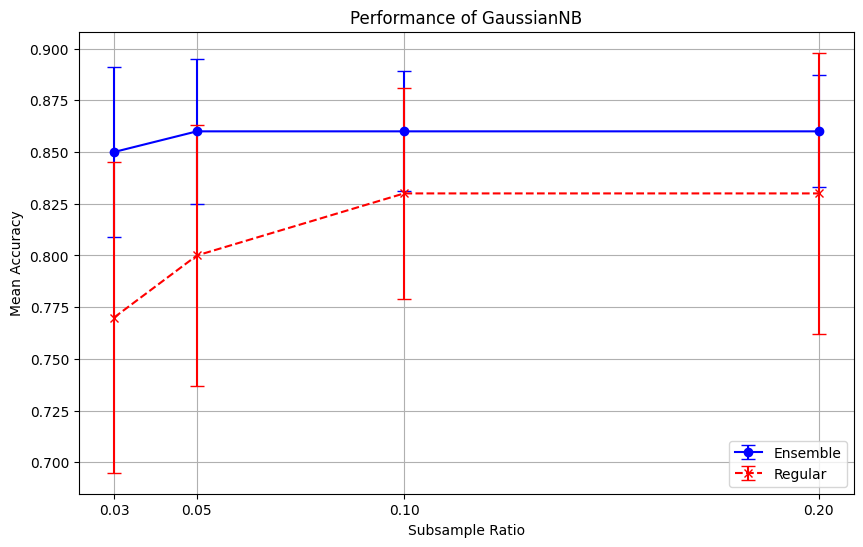

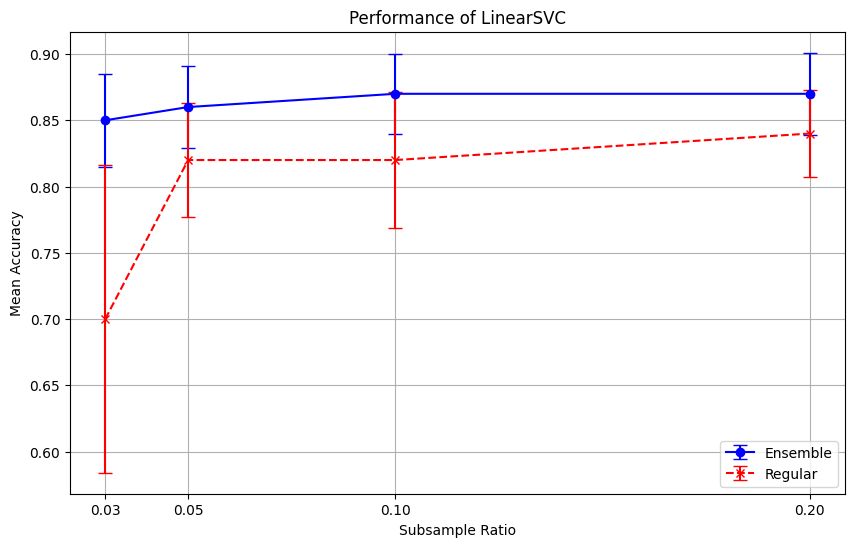

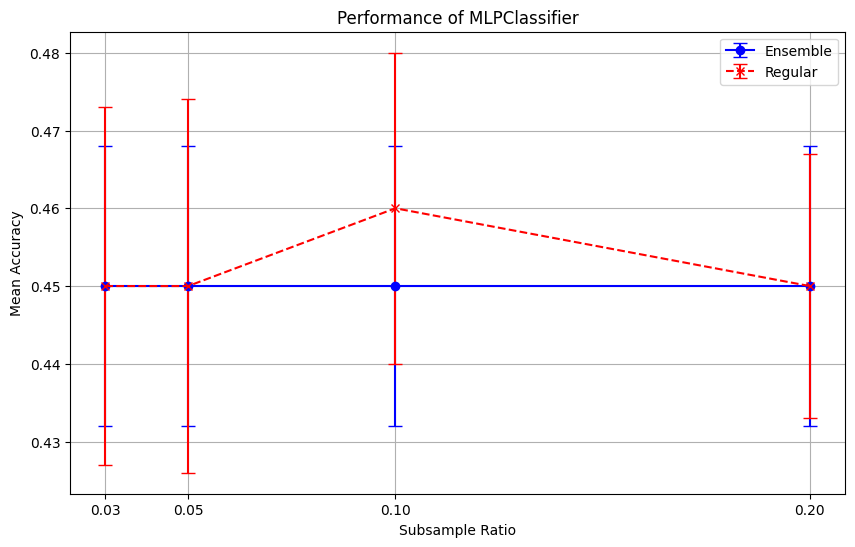

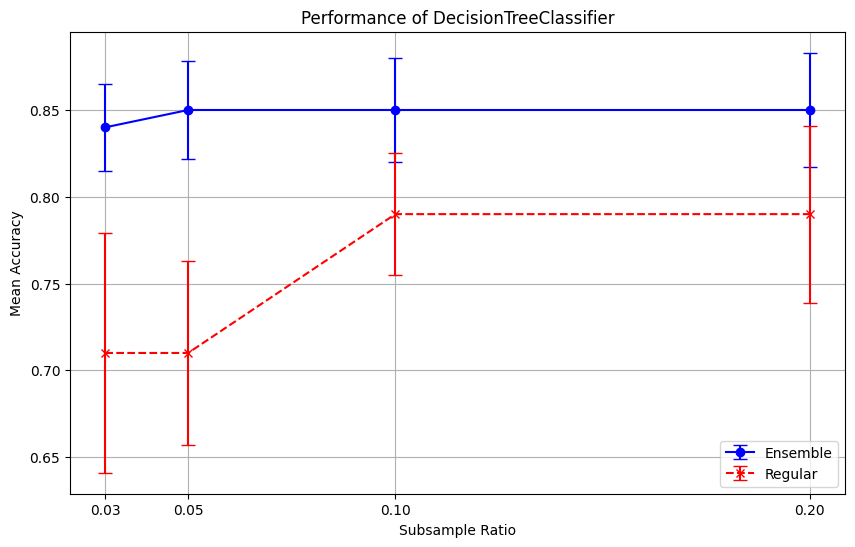

In [456]:
import matplotlib.pyplot as plt

def plot_classifier_performance(subsample_ratios, accuracies_ens, stddev_ens, accuracies_reg, stddev_reg, title):
    plt.figure(figsize=(10, 6))
    plt.errorbar(subsample_ratios, accuracies_ens, yerr=stddev_ens, label='Ensemble', fmt='o-', color='blue', capsize=5)
    plt.errorbar(subsample_ratios, accuracies_reg, yerr=stddev_reg, label='Regular', fmt='x--', color='red', capsize=5)
    plt.title(title)
    plt.xlabel('Subsample Ratio')
    plt.ylabel('Mean Accuracy')
    plt.grid(True)
    plt.xticks(subsample_ratios)
    plt.legend()
    plt.show()

# Plot for each classifier type
plot_classifier_performance(subsample_ratios, gaussian_nb_accuracies_ens, gaussian_nb_stddev_ens, gaussian_nb_accuracies_reg, gaussian_nb_stddev_reg, 'Performance of GaussianNB')
plot_classifier_performance(subsample_ratios, linear_svc_accuracies_ens, linear_svc_stddev_ens, linear_svc_accuracies_reg, linear_svc_stddev_reg, 'Performance of LinearSVC')
plot_classifier_performance(subsample_ratios, mlp_accuracies_ens, mlp_stddev_ens, mlp_accuracies_reg, mlp_stddev_reg, 'Performance of MLPClassifier')
plot_classifier_performance(subsample_ratios, decision_tree_accuracies_ens, decision_tree_stddev_ens, decision_tree_accuracies_reg, decision_tree_stddev_reg, 'Performance of DecisionTreeClassifier')


- For GaussianNB, the ensemble's accuracy remains relatively stable and high compared to the single classifier, which shows some improvement as the subsample size increases. The ensemble technique improves the model’s robustness against overfitting compared to the single GaussianNB classifier.
- For LinearSVC, ensembles shows significantly better performance, especially at lower subsample ratios. While the ensemble and single classifier accuracies converge at higher subsample sizes, the ensemble consistently maintains a lower standard deviation, enhancing model stability.
- For MLPClassifier, both ensembles and single classifiers show poor performance, possibly due to insufficient model complexity or inappropriate hyperparameters for the given task.
- For DecisionTreeClassifier, ensembles consistently perform better than single classifiers, especially in small subsample size.